[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/yue-sun/generative-art/blob/main/03_wednesday/04_reaction_diffusion_systems.ipynb)

# Gray–Scott Model of Reaction–Diffusion Patterns

![reaction-diffusion](https://raw.githubusercontent.com/yue-sun/generative-art/master/03_wednesday/figs/reaction_diffusion.png)

The Gray–Scott model of reaction–diffusion models two interacting components, $U$ and $V$ with concentrations $u$ and $v$ respectively, that both react and diffuse on a 2D grid. This simple model can simulate complex, dynamic, and mesmerizing spatial–temporal patterns like spots, stripes, and mitosis. In this notebook, we will build an interactive Python Gray–Scott simulator with varying patterns and color palettes.

## A little bit of math and physics

Before we starting coding, let us delve into the formulation of the Gray–Scott model to see how reaction, diffusion, and other parameters impact the concentrations $u$ and $v$. As implied by the name, $U$ and $V$ react with each other and diffuse in space.

![gray-scott-label](https://raw.githubusercontent.com/yue-sun/generative-art/master/03_wednesday/figs/gray_scott_label.png)

The reaction between the two components is given by:
$$
\begin{aligned}
U + 2V &\rightarrow 3V \\
V &\rightarrow P
\end{aligned}
$$
where $P$ represents an inert product that depletes the amount of $V$ present. The evolution of concentrations $u$ and $v$ with respect to (w.r.t.) time is given by the following system of partial differential equations (PDEs):

![gray-scott-eq](https://raw.githubusercontent.com/yue-sun/generative-art/master/03_wednesday/figs/gray_scott_eq.png)

Let's break down the contributions to these equations.

### Reaction

According to the chemical reaction, one $U$ and two $V$ produce $3V$; as a result, the reaction _rate_ is proportional to $uv^2$. This reaction effectively converts $U$ into $V$: the increase in $v$ is equivalent to the decrease in $u$.

### Diffusion

$D_u$ and $D_v$ represent the diffusion constants of each component (assuming constants for simplicity), and $\nabla^2$ is the Laplace operator in 2D:
$$
\nabla^2=\frac{\partial^2}{\partial x^2}+\frac{\partial^2}{\partial y^2}
$$
Both $U$ and $V$ respond to the concentrations of their surroundings. Naturally, higher-concentration regions diffuse to lower regions. For example, when the concentration of $U$ is higher at a point than its surroundings, $\nabla^2u$ will be negative, and $u$ will decrease at that point.

### Replenishment

$U$ is replenished from the environment in proportion to $f(1-u)$, where $f$ is a constant known as the _feed rate_. This is the first key parameter we will tune to observe different patterns.

### Depletion

$V$ depletes by forming an inert product $P$. Without depletion, $v$ could increase without limit. This depletion proceeds at a rate proportional to $v$ and the sum $f+k$, where $k$ is a constant known as the _kill rate_. This is the second term we will tune to vary the pattern formation. 

## A basic Gray–Scott simulator

Our goal in this session is to explore the variety of interesting visual patterns this simple yet rich interacting system can exhibit, which have analogs in biological pattern formation. For reference, the following website offers an interactive look into the phase diagram spanned by the $f$ and $k$ parameters: [Reaction-Diffusion by the Gray-Scott Model: Pearson's Parametrization](http://mrob.com/pub/comp/xmorphia/index.html).

We will use numerical integration to simulate the Gray–Scott model, which can be broken down into about five steps:

0. import libraries
1. set physical and simulation parameters
2. initialize two concentrations $u$ and $v$
3. convert PDEs into systems of ordinary differential equations (ODEs)
4. define a function for the right-hand side of ODEs
5. use `solve_ivp` to numerically integrate the function w.r.t. time

We will start by importing the necessary libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import ipywidgets as widgets
from skimage.data import binary_blobs
from skimage.io import imread
from scipy.integrate import solve_ivp
from IPython.display import HTML, display

Below, we define two helper functions to format and make plots and animations.

In [2]:
def plot_pattern(u, colormap='twilight'):
    ''' Plot the concentration as a colored image.
        Inputs:
            u - grid of concentrations of one component
            colormap - an optional specification for a colormap to use
        Outputs:
            fig, ax, im - handles to figure, axis, and image
    '''
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    im = ax.imshow(u, cmap=plt.get_cmap(colormap),
                   vmin=0.2, vmax=1.0,
                   interpolation='bicubic',
                   extent=[-1,1,-1,1], alpha=0.8)
    ax.tick_params(labelsize=14)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    ax.grid(False)

    return fig, ax, im

def animate_pattern(out, colormap='twilight'):
    ''' Animate the concentration over time.
        Inputs:
            out - 3D array of frames
            colormap - an optional specification for a colormap to use
        Outputs:
            ani - handle to animation
    '''
    frames = out.shape[-1]
    fig, ax, im = plot_pattern(out[:,:,0], colormap);

    def animate(i):
        ''' Plot updates for animation.'''
        im.set_array(out[:,:,i])
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True)
    plt.close(fig)
    return ani

We first initialize our reaction–diffusion system, which requires instantiating two $N\times N$ grids:
- one for the concentration $u$ of the first component
- the other for the concentration $v$ of the second component

We will use a built-in function `binary_blobs` to generate a binary image of random, blob-like structures. This image indicates the initial concentration values of the two components:
- where image is 1, set $u=0.5$ and $v=0.25$
- where image is 0, set $u=1$ and $v=0$

We also provide an optional argument to invert the background (where image is 0): instead of a $U$-dominant background, we have $V$-dominant instead. Some patterns can only be realized via this inverted type of initialization.

In [3]:
def init_concentrations(N, inverse=False):
    ''' Initialize concentrations of a two-components system randomly.'''
    mask = binary_blobs(N, blob_size_fraction=0.1, volume_fraction=0.2)
    if inverse:
        u = np.zeros((N, N)); u[mask] = 0.5
        v = np.ones((N, N));  v[mask] = 0.25
    else:
        u = np.ones((N, N));  u[mask] = 0.5
        v = np.zeros((N, N)); v[mask] = 0.25
    return u, v

Let us start with plotting an example of the initial state. Note that you can change the color palette used for plotting by changing the `colormap` argument in `plot_pattern` to the name of one of these [colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

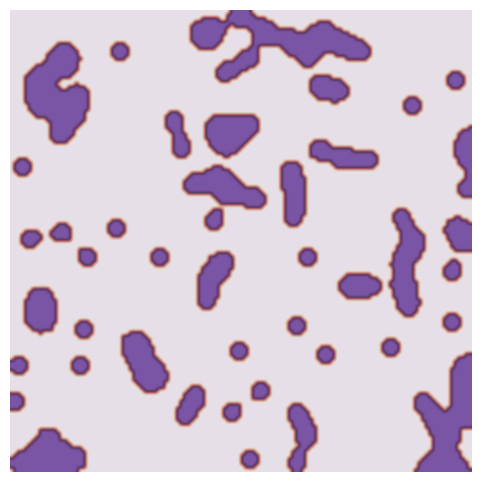

In [4]:
# Initialize
N = 128
u, v = init_concentrations(N)

# Plot the u concentration
fig, ax, im = plot_pattern(u, colormap='twilight');

Next, we need to define another helper function to discretize the Laplacian of each concentration. For example, $\nabla^2u$ is:
$$
\nabla^2u_{i,j} \approx \frac{-4u_{i,j}+u_{i+1,j}+u_{i-1,j}+u_{i,j+1}+u_{i,j-1}}{h^2}
$$
where $h$ is the lattice spacing. We'll use a square domain on $[-1,1]\times [-1,1]$ discretized into $N\times N$ grid points with periodic boundaries; thus our spacing is given by $h=2/N$.

You will notice that the sum of the coefficients of the discrete Laplacian is zero. This enforces mass conservation; since the Laplacian of the concentration is proportional to the rate of inflow or outflow from any point in space, the outflow from any given point must equal the sum of inflow contributions that point makes to any of its neighbors. 

Since we will need to perform two Laplace operations at each integration step, one for each concentration, we define a general function for the Laplace operator that can be repurposed several times.

In [5]:
def laplacian_2d(u, N):
    ''' Compute the Laplacian of concentration over a 2D grid.
        Inputs:
            u - an array of concentrations
            N - the system size in each dimension (2D)
        Outputs:
            lap - the Laplacian of concentration
    '''
    h = 2./N
    invh2 = 1./(h*h)
    lap = (-4*u + np.roll(u, 1, axis=0) \
                + np.roll(u, -1, axis=0) \
                + np.roll(u, 1, axis=1) \
                + np.roll(u, -1, axis=1)) * invh2
    return lap

Our original set of equations is a system of PDEs, but by discretizing the spatial dimensions on an $N\times N$ grid, we convert our system to a set of ODEs with time as the continuous integration variable. The Gray-Scott system of ODEs is defined in the function ```gray_scott``` below.

In [6]:
def gray_scott(t, y, N, Du, Dv, f, k):
    ''' Spatially discretized PDE for the Gray–Scott reaction diffusion system.
        Inputs:
            t - the current time
            y - a flattened array of concentrations u and v
            N - the system size in each dimension
            Du, Dv - the diffusion constants
            f - the feed rate
            k - the kill rate
        Outputs:
            dy - a flattened array of first derivatives of u and v
    '''
    # Unpack concentrations of each component
    u = y[:N*N].reshape(N, N)
    v = y[N*N:].reshape(N, N)

    # Compute the Laplacians
    Lu = laplacian_2d(u, N)
    Lv = laplacian_2d(v, N)

    # Define the first derivatives of u and v w.r.t. time
    du = Du*Lu - u*v*v + f*(1.-u)
    dv = Dv*Lv + u*v*v - (f+k)*v

    # Concatenate two derivatives into one linear array
    dy = np.hstack([du.ravel(), dv.ravel()])
    return dy

Finally, the function `solve` integrates the ODEs using the function `solve_ivp` from the Python `scipy` library.

In [7]:
def solve(func, ti, tf, nt, yi, args):
    ''' Integrates the Gray–Scott model.
        Inputs:
            func - the function to integrate
            ti, tf - start and end integration times
            nt - number of evenly spaced output time points in [ti, tf]
            yi - initial concentrations [u, v]
            args - tuples of model parameters (Du, Dv, a, b, c)
            rtol, atol - tolerance for tuning the accuracy of the solver
        Outputs:
            u - the current concentration of u at the end time
    '''
    u, v = yi                        # unpack initial concentrations
    N = len(u)                       # extract grid dimension
    t_eval = np.linspace(ti, tf, nt) # evaluation time points
    Du, Dv, f, k = args              # unpack extra arguments

    start_time = time.time()         # time the integration

    # Integrate the differential equation using finite differences
    sol = solve_ivp(lambda t, y: func(t, y, N, Du, Dv, f, k), t_span=[ti, tf],
                    y0=np.hstack([u.ravel(), v.ravel()]), t_eval=t_eval, method='RK23')
    u = sol.y[:N*N,:].reshape(N, N, len(t_eval))
    v = sol.y[N*N:,:].reshape(N, N, len(t_eval))

    # Print elapsed time
    print('elapsed time (s):', time.time() - start_time)

    return u

elapsed time (s): 4.304481029510498


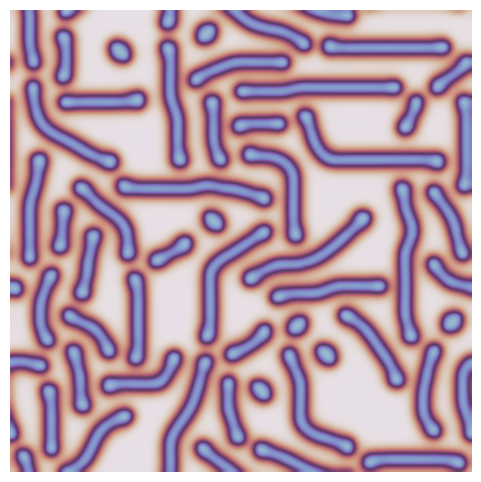

In [8]:
# Set parameters
Du = 2e-5    # diffusion constant of u
Dv = 1e-5    # diffusion constant of v
f = 0.058    # feed rate
k = 0.065    # kill rate

ti = 0       # start time
tf = 6000    # end time
frames = 100 # number of output time points

# Solve and plot u concentration
out = solve(gray_scott, ti, tf, frames, [u, v], args=(Du, Dv, f, k))
fig, ax, im = plot_pattern(out[:,:,-1], colormap='twilight');

In [ ]:
# Create and display animation
ani = animate_pattern(out, colormap='twilight')
HTML(ani.to_html5_video())

## Adding variations

Now that we have set up our integration routine, let us explore some varied patterns of the Gray–Scott model using an interactive widget! The following widget features some presets of the feed and kill rates as starting points. Reference values and type classifications can be found here at ["Pearson's Classification (Extended) of Gray–Scott System Parameter Values"](http://mrob.com/pub/comp/xmorphia/pearson-classes.html).

In [ ]:
@widgets.interact_manual(presets = ['spirals', 'stripes', 'cells', 'worms', 'corals', 'bubbles'])
def interactive_menu_plot(presets='spirals'):
    h = display(display_id=True)
    
    # Preset feed and kill rates
    spirals = [0.010, 0.047] # type alpha
    stripes = [0.026, 0.055] # type gamma
    cells   = [0.026, 0.061] # type lambda
    worms   = [0.058, 0.065] # type mu
    corals  = [0.058, 0.063] # type kappa
    bubbles = [0.090, 0.059] # type rho

    # Get parameters
    f, k = eval(presets)
    Du, Dv = 2e-5, 1e-5

    # Some patterns need to have V-dominant background
    inverse = False
    if presets in ['bubbles']:
        inverse = True
        Du, Dv = 4e-5, 2e-5

    # Initialize u and v
    N = 128
    u, v = init_concentrations(N, inverse)

    # Solve
    ti, tf = 0, 6000
    frames = 100
    out = solve(gray_scott, ti, tf, frames, [u, v], args=(Du, Dv, f, k))

    # Create and display animation
    print('creating animation...')
    ani = animate_pattern(out, colormap='twilight')
    h.display(HTML(ani.to_html5_video()))

To more easily vary the model parameters, we add two sliders to change the feed and kill rates.

In [ ]:
feed_slider = widgets.FloatSlider(
    value=0.03, min=0.01, max=0.11, step=0.001,
    description='Feed rate:', readout_format='.3f',)
kill_slider = widgets.FloatSlider(
    value=0.057, min=0.04, max=0.07, step=0.001,
    description='Kill rate:', readout_format='.3f',)

@widgets.interact_manual(f=feed_slider, k=kill_slider, inverse=['True', 'False'])
def interactive_slider_plot(f=0.03, k=0.057, inverse='False'):
    h = display(display_id=True)

    # Initialize u and v
    N = 128
    u, v = init_concentrations(N, eval(inverse))

    # Solve
    Du, Dv = 2e-5, 1e-5
    ti, tf = 0, 6000
    frames = 100
    out = solve(gray_scott, ti, tf, frames, [u, v], args=(Du, Dv, f, k))

    # Create and display animation
    print('creating animation...')
    ani = animate_pattern(out, colormap='twilight')
    h.display(HTML(ani.to_html5_video()))

We can also seed the reaction with an image! A number of different silhouettes are provided in the GitHub repository.

In [ ]:
import cv2

# Convert a black and white image to a mask (resizing as necessary)
def init_seed_concentrations(N, image, inverse=False):
    ''' Initialize concentrations of a two-components system based on seed image.'''
    mask = imread('figs/seeds/'+image+'.png', as_gray=True)
    m, n = mask.shape
    scale = 128./min(m, n)
    width = int(n*scale)
    height = int(m*scale)
    dim = (width, height)
    mask = cv2.resize(mask, dim)
    m, n = mask.shape
    mask = mask[m//2-N//2:m//2+N//2, n//2-N//2:n//2+N//2]
    mask[mask > 0] = 1
    mask = np.logical_not(mask)

    # Initialize concentrations
    if inverse:
        u = np.zeros((N, N)); u[mask] = 0.5
        v = np.ones((N, N));  v[mask] = 0.25
    else:
        u = np.ones((N, N));  u[mask] = 0.5
        v = np.zeros((N, N)); v[mask] = 0.25
    return u, v

In [ ]:
# Run the cell if you are running the notebook on Google Colab
!git clone https://github.com/yue-sun/generative-art.git
%cd generate-art/03_wednesday
# Print contents
%ls figs/seeds

In [ ]:
# Initialize u and v based on seed image
N = 128
u, v = init_seed_concentrations(N, 'shield')
plot_pattern(u, colormap='twilight');

In [ ]:
# Set parameters
Du, Dv = 2e-5, 1e-5
f, k = 0.0545, 0.062
ti, tf = 0, 6000
frames = 100

# Solve and plot u concentration
out = solve(gray_scott, ti, tf, frames, [u, v], args=(Du, Dv, f, k))
fig, ax, im = plot_pattern(out[:,:,-1], colormap='twilight');

In [ ]:
# Create and display animation
ani = animate_pattern(out, colormap='twilight')
HTML(ani.to_html5_video())

Finally, let us combine everything together with options to add custom color palettes! To design your own colormap, you can add to the Hex color codes in `reaction_diffusion_utils.py`. _You may need to restart the kernel after making adjustments to the file given how Jupyter notebook import works._ We also need to modify `plot_pattern` and `animate_pattern` because the custom colormaps cannot be return by `plt.get_cmap()`.

In [ ]:
from reaction_diffusion_utils import custom_cmap

def plot_pattern(u, colormap='twilight', custom=False):
    ''' Plot the concentration as a colored image.
        Inputs:
            u - grid of concentrations of one component
            colormap - an optional specification for a colormap to use
            custom - whether to use built-in or custom colormap
        Outputs:
            fig, ax, im - handles to figure, axis, and image
    '''
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    if custom:
        cmap=custom_cmap(colormap)
    else:
        cmap=plt.get_cmap(colormap)
    im = ax.imshow(u, cmap=cmap,
                   vmin=0.2, vmax=1.0,
                   interpolation='bicubic',
                   extent=[-1,1,-1,1], alpha=0.8)
    ax.tick_params(labelsize=14)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    ax.grid(False)

    return fig, ax, im

def animate_pattern(out, colormap='twilight', custom=False):
    ''' Animate the concentration over time.
        Inputs:
            out - 3D array of frames
            colormap - an optional specification for a colormap to use
            custom - whether to use built-in or custom colormap
        Outputs:
            ani - handle to animation
    '''
    frames = out.shape[-1]
    fig, ax, im = plot_pattern(out[:,:,0], colormap, custom);

    def animate(i):
        ''' Plot updates for animation.'''
        im.set_array(out[:,:,i])
        return im,

    ani = animation.FuncAnimation(fig, animate, frames=frames, interval=100, blit=True)
    plt.close(fig)
    return ani

@widgets.interact_manual(presets = ['spirals', 'stripes', 'cells', 'worms', 'corals', 'bubbles'],
                         colormaps = ['pastel rainbow', 'great wave', 'girl pearl earring', 'starry night', 'water lilies', 'sunset'],
                         seeds = ['dinosaur','dot', 'heart', 'moon', 'pretzel', 'shield'])
def interactive_menu_plot(presets='spirals', colormaps='great wave', seeds='shield'):
    h = display(display_id=True)
    
    # Preset feed and kill rates
    spirals = [0.010, 0.047] # type alpha
    stripes = [0.026, 0.055] # type gamma
    cells   = [0.026, 0.061] # type lambda
    worms   = [0.058, 0.065] # type mu
    corals  = [0.058, 0.063] # type kappa
    bubbles = [0.090, 0.059] # type rho

    # Get parameters
    f, k = eval(presets)
    Du, Dv = 2e-5, 1e-5

    # Some patterns need to have V-dominant background
    inverse = False
    if presets in ['bubbles']:
        inverse = True
        Du, Dv = 4e-5, 2e-5

    # Initialize u and v
    N = 128
    u, v = init_seed_concentrations(N, seeds, inverse)

    # Solve
    ti, tf = 0, 6000
    frames = 100
    out = solve(gray_scott, ti, tf, frames, [u, v], args=(Du, Dv, f, k))

    # Create and display animation
    print('creating animation...')
    ani = animate_pattern(out, colormap=colormaps, custom=True)
    h.display(HTML(ani.to_html5_video()))